In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.parametrizations import weight_norm
from torch.utils.data import Dataset, DataLoader, Subset
from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import logging

In [181]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Data Importing

In [182]:
df_train = pd.read_csv("./.data/train_pp_aug.csv")

### Data Checking

In [183]:
print(df_train)

               id p_num                 time   bg-5:55   bg-5:50   bg-5:45  \
0         p01_335   p01  1900-01-01 00:00:00 -1.457445 -1.457493 -1.347342   
1         p01_994   p01  1900-01-01 00:00:00  0.238902  0.239084  0.297699   
2        p01_1554   p01  1900-01-01 00:00:00  0.671304  0.671545  0.661106   
3        p01_1649   p01  1900-01-01 00:00:00 -0.027192 -0.027046 -0.093449   
4        p01_2101   p01  1900-01-01 00:00:00 -0.093715 -0.093578  0.072997   
...           ...   ...                  ...       ...       ...       ...   
354043  p12_24204   p12  1900-01-01 23:55:00 -0.295896 -0.279907 -0.308338   
354044  p12_24434   p12  1900-01-01 23:55:00  0.283060  0.272823  0.273607   
354045  p12_24722   p12  1900-01-01 23:55:00  1.242435  1.036898  0.939870   
354046  p12_25010   p12  1900-01-01 23:55:00  0.145258  0.093776  0.178915   
354047  p12_25298   p12  1900-01-01 23:55:00  0.514745  0.643771  0.703263   

         bg-5:40   bg-5:35   bg-5:30   bg-5:25  ...  cals-0:40 

In [184]:
for col in df_train.columns:
    print(col)

id
p_num
time
bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin

In [185]:
meta_data = ['id', 'p_num', 'time']

df_train_meta = df_train[meta_data]
df_train.drop(columns=meta_data, inplace=True)

print(df_train_meta.shape)
print(df_train.shape)

(354048, 3)
(354048, 433)


In [186]:
# sensor_types = ["bg", "insulin", "carbs", "hr", "steps", "cals"]
# sensor_cols = [col for col in df_train.columns if any(col.startswith(s + "-") for s in sensor_types)]
# print(sensor_cols)

# df_train_features = df_train[sensor_cols]
# df_train_target = df_train.drop(columns=sensor_cols)

# print(df_train_features.shape)
# print(df_train_target.shape)

### Dataset and DataLoader

In [ ]:
# class GDataset(Dataset):
#     def __init__(self, df):
#         """
#         Expects a DataFrame that has been processed by the previous script.
#         Excludes the columns: "id", "p_num", "time", and "bg+1:00" (target).
#         Assumes that the remaining numeric columns are grouped by sensor type.
#         There are 6 sensor types: ["bg", "insulin", "carbs", "hr", "steps", "cals"].
#         Each sensor type contributes 72 time steps (i.e. 6 hours of 5-min intervals).
#         The returned sample is reshaped to (seq_len, num_channels) = (72, 6).
#         """
        
#         self.targets = df["bg+1:00"].values.astype(np.float32)
        
#         sensor_types = ["bg", "insulin", "carbs", "hr", "steps", "cals"]
#         channels_data = []

#         for sensor in sensor_types:
#             sensor_cols = [col for col in df.columns if col.startswith(sensor + "-")]

#             sensor_cols = sorted(sensor_cols, key=lambda x: int(x.split("-")[1].split(":")[0]) * 60 + int(x.split("-")[1].split(":")[1]))
#             channels_data.append(df[sensor_cols].values.astype(np.float32))
        
#         self.seq_len = channels_data[0].shape[1]
#         for arr in channels_data:
#             assert arr.shape[1] == self.seq_len, "Mismatch!"
        
#         self.data = np.stack(channels_data, axis=2)
        
#     def __len__(self):
#         return len(self.targets)
    
#     def __getitem__(self, idx):
#         x = self.data[idx]
#         y = self.targets[idx]
#         return torch.from_numpy(x), torch.tensor(y)


class GDataset(Dataset):
    def __init__(self, features: pd.DataFrame, targets: pd.DataFrame, seq_len=72, num_channels=6):
        """
        features: DataFrame with shape (n_samples, seq_len * num_channels)
        targets: DataFrame or Series with shape (n_samples,)
        Assumes that features are ordered such that for each time step, the 6 channels are stacked together,
        OR that columns are grouped per sensor type but already time-ordered correctly.
        """
        self.targets = targets.values.astype(np.float32).flatten()
        self.data = features.values.astype(np.float32)
        
        self.data = self.data.reshape(-1, seq_len, num_channels)
        print((self.targets).shape)
        print((self.data).shape)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return torch.from_numpy(x), torch.tensor(y)

In [ ]:
# dataset = GDataset(df_train)
dataset = GDataset(df_train_features, df_train_target)
indices = np.arange(len(dataset))

In [189]:
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

In [190]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [191]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [192]:
class MultiScaleTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, dropout=0.2):
        super().__init__()
        self.branch1 = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                                            padding=dilation, dilation=dilation))
        self.branch2 = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size=5, 
                                             padding=2 * dilation, dilation=dilation))
        self.conv1x1 = weight_norm(nn.Conv1d(2 * out_channels, out_channels, kernel_size=1))
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size=1))
            
    def forward(self, x):
        out1 = self.relu(self.branch1(x))
        out1 = self.dropout(out1)
        out2 = self.relu(self.branch2(x))
        out2 = self.dropout(out2)
        
        out = torch.cat([out1, out2], dim=1)
        out = self.relu(self.conv1x1(out))
        
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

In [193]:
class MultiScaleTCN(nn.Module):
    def __init__(self, input_channels, num_blocks, hidden_channels, dropout=0.2):
        """
        input_channels: number of channels in the input sequence (e.g. 6).
        num_blocks: number of stacked TCN blocks.
        hidden_channels: number of filters in each TCN block.
        """
        super().__init__()
        layers = []
        in_channels = input_channels
        dilation = 1
        for _ in range(num_blocks):
            layers.append(MultiScaleTCNBlock(in_channels, hidden_channels, dilation=dilation, dropout=dropout))
            in_channels = hidden_channels
            dilation *= 2
        self.tcn = nn.Sequential(*layers)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(hidden_channels, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.tcn(x)
        out = self.global_pool(out).squeeze(-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out.squeeze(-1)

In [194]:
model = MultiScaleTCN(input_channels=6, num_blocks=4, hidden_channels=64, dropout=0.2)
model.to(device)

MultiScaleTCN(
  (tcn): Sequential(
    (0): MultiScaleTCNBlock(
      (branch1): ParametrizedConv1d(
        6, 64, kernel_size=(3,), stride=(1,), padding=(1,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (branch2): ParametrizedConv1d(
        6, 64, kernel_size=(5,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (conv1x1): ParametrizedConv1d(
        128, 64, kernel_size=(1,), stride=(1,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (downsample): ParametrizedConv1d(
        6, 64, kernel_size=(1,), stride=(1,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(

#### Model Summary

In [195]:
dummy_seq = torch.randn(1, 72, 6).to(device)

In [196]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                                  Output Shape              Param #
MultiScaleTCN                                           [1]                       --
├─Sequential: 1-1                                       [1, 64, 72]               --
│    └─MultiScaleTCNBlock: 2-1                          [1, 64, 72]               --
│    │    └─ParametrizedConv1d: 3-1                     [1, 64, 72]               1,280
│    │    └─ReLU: 3-2                                   [1, 64, 72]               --
│    │    └─Dropout: 3-3                                [1, 64, 72]               --
│    │    └─ParametrizedConv1d: 3-4                     [1, 64, 72]               2,048
│    │    └─ReLU: 3-5                                   [1, 64, 72]               --
│    │    └─Dropout: 3-6                                [1, 64, 72]               --
│    │    └─ParametrizedConv1d: 3-7                     [1, 64, 72]               8,320
│    │    └─ReLU: 3-8               

#### Model Computational Graph

In [197]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


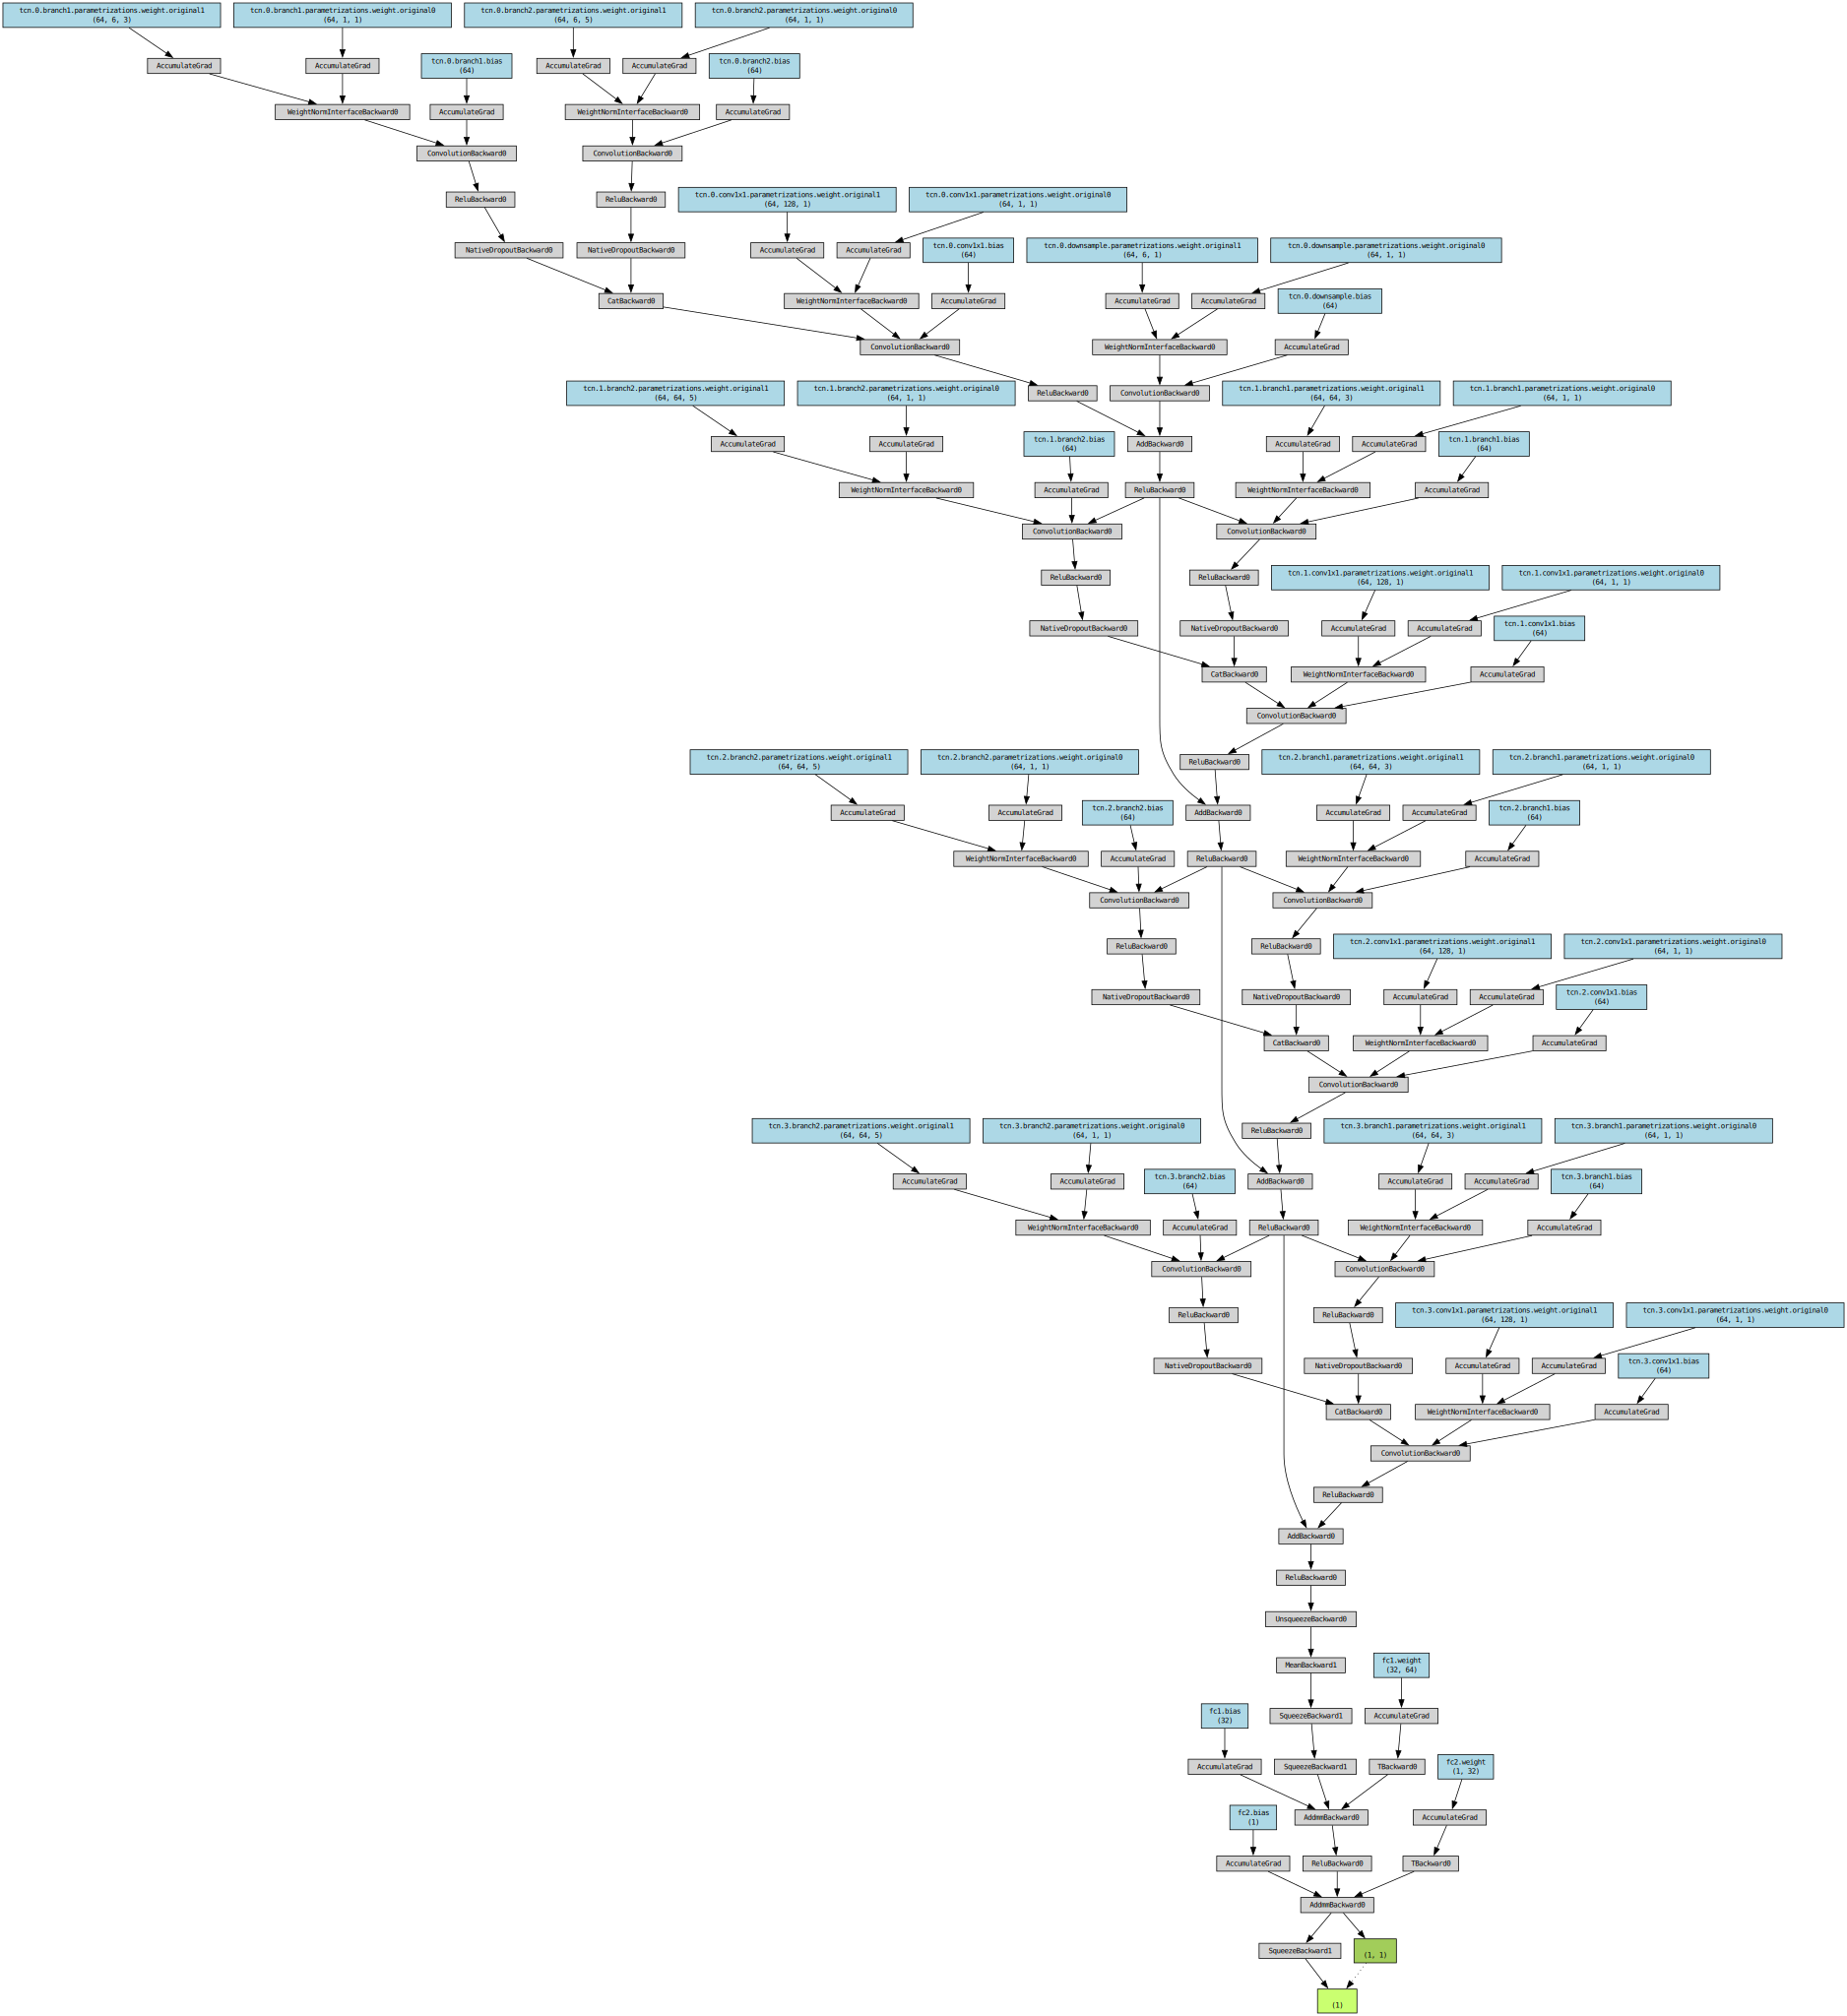

In [198]:
print("Model Computational Graph:")
display(dot)

### Training

In [199]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [200]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Stops training if validation loss does not improve after 'patience' epochs.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), './.export/checkpoint-aug.pt')
        self.val_loss_min = val_loss

In [201]:
num_epochs = 200
early_stopping = EarlyStopping(patience=10, verbose=True)
train_losses, val_losses = [], []

In [202]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Training
    for inputs, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1} (Train)", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1} (Validation)", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("EarlyStopping!")
        break

Epoch: 1/200 | Train Loss: 5.1244 | Val Loss: 3.8745


Epoch: 2/200 | Train Loss: 4.0031 | Val Loss: 3.7979


Epoch: 3/200 | Train Loss: 3.8336 | Val Loss: 3.6058


Epoch: 4/200 | Train Loss: 3.7067 | Val Loss: 3.5139


Epoch: 5/200 | Train Loss: 3.5941 | Val Loss: 3.3411


Epoch: 6/200 | Train Loss: 3.4559 | Val Loss: 3.2495


Epoch: 7/200 | Train Loss: 3.3385 | Val Loss: 3.1181


Epoch: 8/200 | Train Loss: 3.1934 | Val Loss: 3.0662


Epoch: 9/200 | Train Loss: 3.0522 | Val Loss: 2.7936


Epoch: 10/200 | Train Loss: 2.9078 | Val Loss: 2.7209


Epoch: 11/200 | Train Loss: 2.7667 | Val Loss: 2.4977


Epoch: 12/200 | Train Loss: 2.6439 | Val Loss: 2.6116
EarlyStopping: 1/10


Epoch: 13/200 | Train Loss: 2.5248 | Val Loss: 2.2457


Epoch: 14/200 | Train Loss: 2.4157 | Val Loss: 2.2114


Epoch: 15/200 | Train Loss: 2.3149 | Val Loss: 2.1330


Epoch: 16/200 | Train Loss: 2.2237 | Val Loss: 2.3882
EarlyStopping: 1/10


Epoch: 17/200 | Train Loss: 2.1436 | Val Loss: 1.9370


Epoch: 18/200 | Train Loss: 2.0670 | Val Loss: 1.9178


Epoch: 19/200 | Train Loss: 1.9924 | Val Loss: 1.9386
EarlyStopping: 1/10


Epoch: 20/200 | Train Loss: 1.9257 | Val Loss: 1.6707


Epoch: 21/200 | Train Loss: 1.8725 | Val Loss: 1.7690
EarlyStopping: 1/10


Epoch: 22/200 | Train Loss: 1.8109 | Val Loss: 1.5507


Epoch: 23/200 | Train Loss: 1.7735 | Val Loss: 1.7431
EarlyStopping: 1/10


Epoch: 24/200 | Train Loss: 1.7179 | Val Loss: 1.5304


Epoch: 25/200 | Train Loss: 1.6815 | Val Loss: 1.5690
EarlyStopping: 1/10


Epoch: 26/200 | Train Loss: 1.6506 | Val Loss: 1.3893


Epoch: 27/200 | Train Loss: 1.6053 | Val Loss: 1.5659
EarlyStopping: 1/10


Epoch: 28/200 | Train Loss: 1.5717 | Val Loss: 1.2897


Epoch: 29/200 | Train Loss: 1.5459 | Val Loss: 1.3363
EarlyStopping: 1/10


Epoch: 30/200 | Train Loss: 1.5150 | Val Loss: 1.3283
EarlyStopping: 2/10


Epoch: 31/200 | Train Loss: 1.4889 | Val Loss: 1.2889


Epoch: 32/200 | Train Loss: 1.4603 | Val Loss: 1.2232


Epoch: 33/200 | Train Loss: 1.4429 | Val Loss: 1.1960


Epoch: 34/200 | Train Loss: 1.4152 | Val Loss: 1.2093
EarlyStopping: 1/10


Epoch: 35/200 | Train Loss: 1.3995 | Val Loss: 1.1948


Epoch: 36/200 | Train Loss: 1.3748 | Val Loss: 1.3202
EarlyStopping: 1/10


Epoch: 37/200 | Train Loss: 1.3555 | Val Loss: 1.1996
EarlyStopping: 2/10


Epoch: 38/200 | Train Loss: 1.3492 | Val Loss: 1.2747
EarlyStopping: 3/10


Epoch: 39/200 | Train Loss: 1.3157 | Val Loss: 1.0794


Epoch: 40/200 | Train Loss: 1.3056 | Val Loss: 1.0040


Epoch: 41/200 | Train Loss: 1.2877 | Val Loss: 1.0651
EarlyStopping: 1/10


Epoch: 42/200 | Train Loss: 1.2706 | Val Loss: 1.0087
EarlyStopping: 2/10


Epoch: 43/200 | Train Loss: 1.2616 | Val Loss: 1.1763
EarlyStopping: 3/10


Epoch: 44/200 | Train Loss: 1.2453 | Val Loss: 1.0821
EarlyStopping: 4/10


Epoch: 45/200 | Train Loss: 1.2330 | Val Loss: 1.0682
EarlyStopping: 5/10


Epoch: 46/200 | Train Loss: 1.2200 | Val Loss: 1.0765
EarlyStopping: 6/10


Epoch: 47/200 | Train Loss: 1.2127 | Val Loss: 0.9659


Epoch: 48/200 | Train Loss: 1.1951 | Val Loss: 1.0154
EarlyStopping: 1/10


Epoch: 49/200 | Train Loss: 1.1870 | Val Loss: 1.1119
EarlyStopping: 2/10


Epoch: 50/200 | Train Loss: 1.1711 | Val Loss: 1.1407
EarlyStopping: 3/10


Epoch: 51/200 | Train Loss: 1.1692 | Val Loss: 0.9441


Epoch: 52/200 | Train Loss: 1.1572 | Val Loss: 0.9082


Epoch: 53/200 | Train Loss: 1.1460 | Val Loss: 0.9748
EarlyStopping: 1/10


Epoch: 54/200 | Train Loss: 1.1330 | Val Loss: 0.9078


Epoch: 55/200 | Train Loss: 1.1283 | Val Loss: 0.8379


Epoch: 56/200 | Train Loss: 1.1219 | Val Loss: 0.8412
EarlyStopping: 1/10


Epoch: 57/200 | Train Loss: 1.1152 | Val Loss: 0.8772
EarlyStopping: 2/10


Epoch: 58/200 | Train Loss: 1.1027 | Val Loss: 0.8302


Epoch: 59/200 | Train Loss: 1.0953 | Val Loss: 0.8667
EarlyStopping: 1/10


Epoch: 60/200 | Train Loss: 1.0902 | Val Loss: 0.9772
EarlyStopping: 2/10


Epoch: 61/200 | Train Loss: 1.0807 | Val Loss: 0.8690
EarlyStopping: 3/10


Epoch: 62/200 | Train Loss: 1.0743 | Val Loss: 0.8329
EarlyStopping: 4/10


Epoch: 63/200 | Train Loss: 1.0717 | Val Loss: 0.9695
EarlyStopping: 5/10


Epoch: 64/200 | Train Loss: 1.0596 | Val Loss: 0.8001


Epoch: 65/200 | Train Loss: 1.0563 | Val Loss: 0.8927
EarlyStopping: 1/10


Epoch: 66/200 | Train Loss: 1.0460 | Val Loss: 0.9624
EarlyStopping: 2/10


Epoch: 67/200 | Train Loss: 1.0414 | Val Loss: 0.8371
EarlyStopping: 3/10


Epoch: 68/200 | Train Loss: 1.0410 | Val Loss: 0.8621
EarlyStopping: 4/10


Epoch: 69/200 | Train Loss: 1.0297 | Val Loss: 0.7954


Epoch: 70/200 | Train Loss: 1.0266 | Val Loss: 0.9406
EarlyStopping: 1/10


Epoch: 71/200 | Train Loss: 1.0153 | Val Loss: 0.8398
EarlyStopping: 2/10


Epoch: 72/200 | Train Loss: 1.0168 | Val Loss: 0.7973
EarlyStopping: 3/10


Epoch: 73/200 | Train Loss: 1.0066 | Val Loss: 0.9248
EarlyStopping: 4/10


Epoch: 74/200 | Train Loss: 1.0052 | Val Loss: 0.7716


Epoch: 75/200 | Train Loss: 1.0001 | Val Loss: 0.7337


Epoch: 76/200 | Train Loss: 0.9931 | Val Loss: 0.7843
EarlyStopping: 1/10


Epoch: 77/200 | Train Loss: 0.9906 | Val Loss: 0.7450
EarlyStopping: 2/10


Epoch: 78/200 | Train Loss: 0.9841 | Val Loss: 0.8193
EarlyStopping: 3/10


Epoch: 79/200 | Train Loss: 0.9765 | Val Loss: 0.7159


Epoch: 80/200 | Train Loss: 0.9679 | Val Loss: 0.7526
EarlyStopping: 1/10


Epoch: 81/200 | Train Loss: 0.9765 | Val Loss: 0.7755
EarlyStopping: 2/10


Epoch: 82/200 | Train Loss: 0.9679 | Val Loss: 0.8327
EarlyStopping: 3/10


Epoch: 83/200 | Train Loss: 0.9628 | Val Loss: 0.7958
EarlyStopping: 4/10


Epoch: 84/200 | Train Loss: 0.9599 | Val Loss: 0.8196
EarlyStopping: 5/10


Epoch: 85/200 | Train Loss: 0.9531 | Val Loss: 0.7003


Epoch: 86/200 | Train Loss: 0.9480 | Val Loss: 0.7691
EarlyStopping: 1/10


Epoch: 87/200 | Train Loss: 0.9450 | Val Loss: 0.7542
EarlyStopping: 2/10


Epoch: 88/200 | Train Loss: 0.9450 | Val Loss: 0.7286
EarlyStopping: 3/10


Epoch: 89/200 | Train Loss: 0.9373 | Val Loss: 0.9053
EarlyStopping: 4/10


Epoch: 90/200 | Train Loss: 0.9317 | Val Loss: 0.6845


Epoch: 91/200 | Train Loss: 0.9349 | Val Loss: 0.8748
EarlyStopping: 1/10


Epoch: 92/200 | Train Loss: 0.9259 | Val Loss: 0.7460
EarlyStopping: 2/10


Epoch: 93/200 | Train Loss: 0.9185 | Val Loss: 0.6857
EarlyStopping: 3/10


Epoch: 94/200 | Train Loss: 0.9206 | Val Loss: 0.7451
EarlyStopping: 4/10


Epoch: 95/200 | Train Loss: 0.9173 | Val Loss: 0.7199
EarlyStopping: 5/10


Epoch: 96/200 | Train Loss: 0.9118 | Val Loss: 0.6957
EarlyStopping: 6/10


Epoch: 97/200 | Train Loss: 0.9103 | Val Loss: 0.7021
EarlyStopping: 7/10


Epoch: 98/200 | Train Loss: 0.9093 | Val Loss: 0.7488
EarlyStopping: 8/10


Epoch: 99/200 | Train Loss: 0.9005 | Val Loss: 0.6871
EarlyStopping: 9/10


Epoch: 100/200 | Train Loss: 0.8957 | Val Loss: 0.7172
EarlyStopping: 10/10
EarlyStopping!


In [203]:
# print("Training Performance:")
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

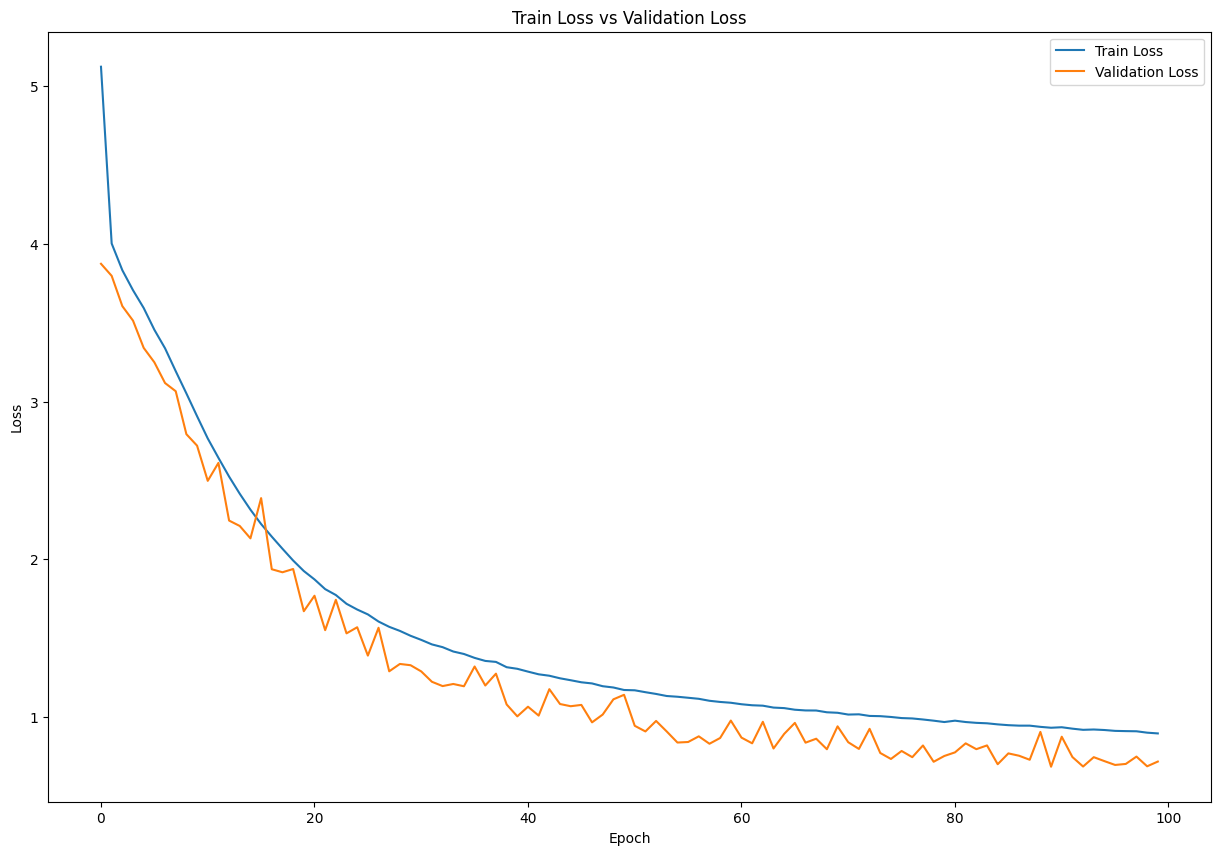

In [204]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [205]:
model.load_state_dict(torch.load('./.export/checkpoint-aug.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_53808\671070252.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug.pt'

<All keys matched successfully>

In [206]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [207]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
residuals = all_preds - all_targets

Evaluation: 100%|██████████| 277/277 [00:01<00:00, 195.38it/s]


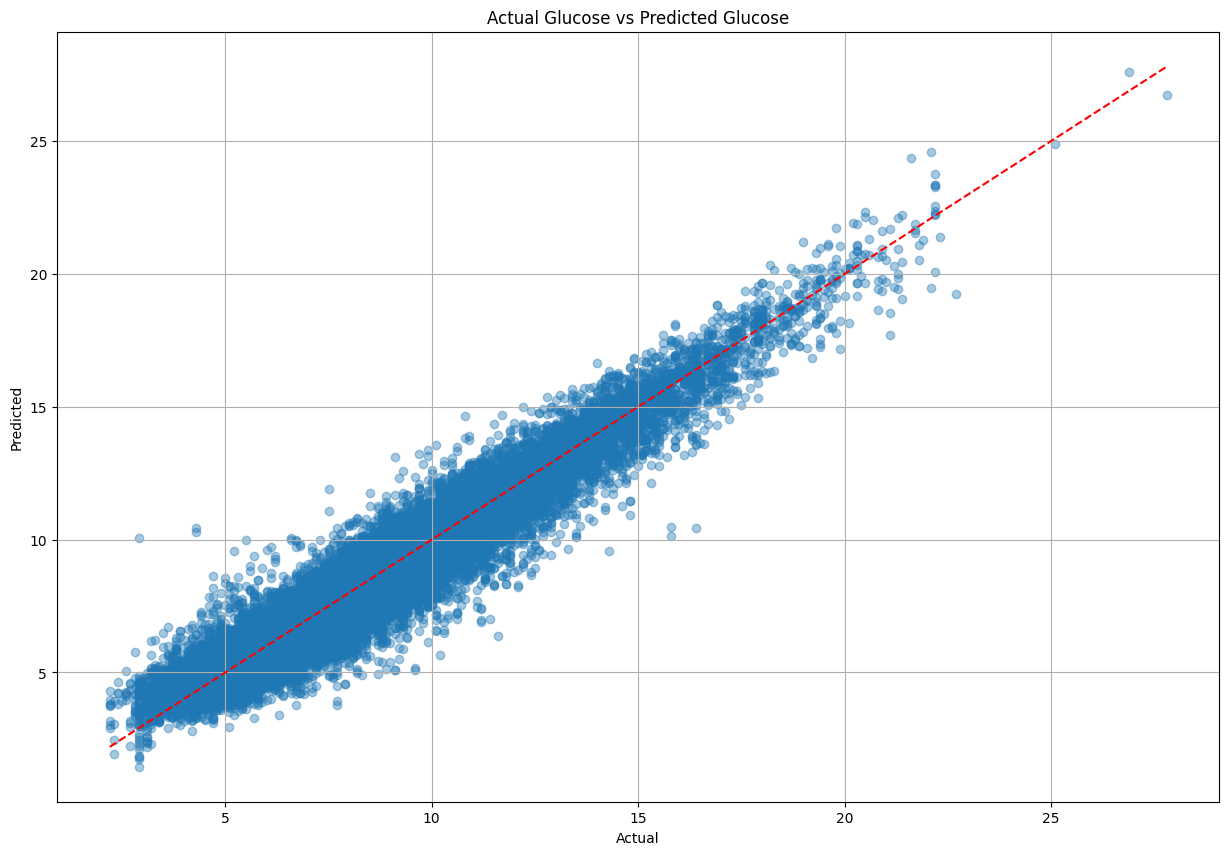

In [208]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

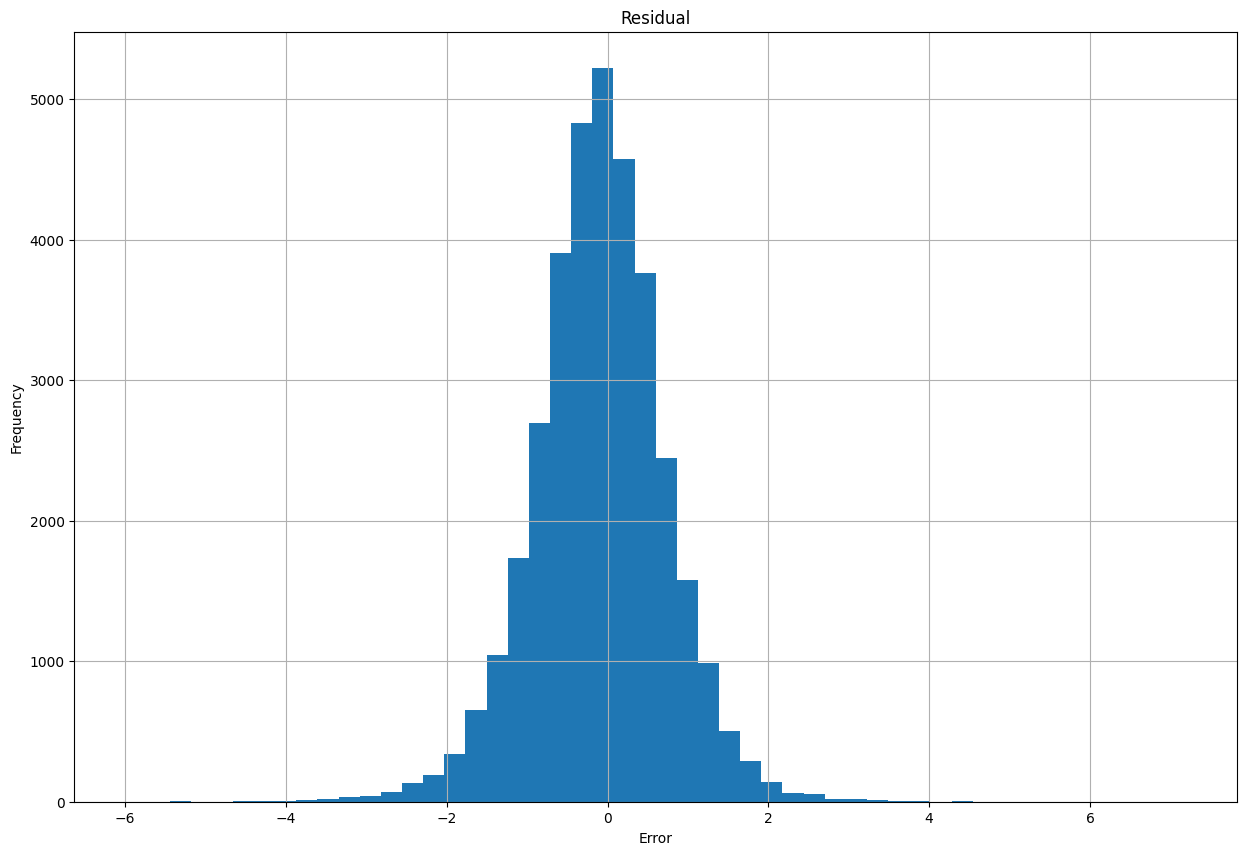

In [209]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [210]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [211]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [212]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
# test_r2 = r2_score(all_targets, all_preds)
# test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_pearson = pearson_r(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [213]:
print("Global Score")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test Pearson r: {test_pearson:.4f}")
print(f"Test CCC: {test_ccc:.4f}")

Global Score
Test RMSE: 0.8213
Test MAE: 0.6239
Test MARD: 0.0825
Test MBE: -0.0971
Test R²: 0.9239
Test Explained Variance: 0.9249
Test MAPE: 8.25%
Test Pearson r: 0.9625
Test CCC: 0.9620


### Inference

In [214]:
df_test = pd.read_csv("./.data/test_pp_aug.csv")

In [ ]:
for col in df_test.columns:
    print(col)

bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin-3:20
insulin-

In [216]:
meta_data = ['id', 'p_num', 'time']

df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [ ]:
# class GDatasetInference(Dataset):
#     def __init__(self, df):
#         """
#         Expects a DataFrame that has been processed by the previous script.
#         Excludes the columns: "id", "p_num", "time", and "bg+1:00" (target).
#         Assumes that the remaining numeric columns are grouped by sensor type.
#         There are 6 sensor types: ["bg", "insulin", "carbs", "hr", "steps", "cals"].
#         Each sensor type contributes 72 time steps (i.e. 6 hours of 5-min intervals).
#         The returned sample is reshaped to (seq_len, num_channels) = (72, 6).
#         """
        
#         # self.targets = df["bg+1:00"].values.astype(np.float32)
        
#         sensor_types = ["bg", "insulin", "carbs", "hr", "steps", "cals"]
#         channels_data = []

#         for sensor in sensor_types:
#             sensor_cols = [col for col in df.columns if col.startswith(sensor + "-")]

#             sensor_cols = sorted(sensor_cols, key=lambda x: int(x.split("-")[1].split(":")[0]) * 60 + int(x.split("-")[1].split(":")[1]))
#             channels_data.append(df[sensor_cols].values.astype(np.float32))
        
#         self.seq_len = channels_data[0].shape[1]
#         for arr in channels_data:
#             assert arr.shape[1] == self.seq_len, "Mismatch!"
        
#         self.data = np.stack(channels_data, axis=2)
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         x = self.data[idx]
#         # y = self.targets[idx]
#         return torch.from_numpy(x)

class GDatasetInference(Dataset):
    def __init__(self, features: pd.DataFrame, seq_len=72, num_channels=6):
        """
        features: DataFrame of shape (n_samples, seq_len * num_channels)
        Assumes features are time-ordered and already cleaned.
        """
        self.data = features.values.astype(np.float32)
        self.data = self.data.reshape(-1, seq_len, num_channels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.from_numpy(x)

In [218]:
infer_test_dataset = GDatasetInference(df_test)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=128, shuffle=False)

In [219]:
model.eval()
predictions = []

with torch.no_grad():
    for inputs in tqdm(infer_test_loader, desc="Inference"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        
predictions = np.array(predictions)
df_predictions = pd.DataFrame(predictions, columns=["bg+1:00"])

Inference: 100%|██████████| 29/29 [00:00<00:00, 260.89it/s]


In [ ]:
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.drop(columns=['p_num', 'time'], inplace=True)
df_results.to_csv("./.export/test_submission_aug.csv", index=False)